# Определение стоимости автомобилей

Cервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

**Цель исследования:**

Построим модель, которая умеет определять рыночную стоимость автомобиля. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

**Описание данных:**

Набор данных находится в файле `/datasets/autos.csv`. О качестве данных ничего не известно.

Признаки:
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя
    
Целевой признак:
* `Price` — цена (евро)

**Ход исследования:** 

	Загрузим данные, путь к файлу:  /datasets/autos.csv.
	Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.
	Подготовим выборки для обучения моделей.
	Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
	Проанализируем время обучения, время предсказания и качество моделей.
	Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

Таким образом, исследование пройдёт несколько этапов:
 1. Загрузка и подготовка данных.
 2. Обучение моделей.
 3. Анализ моделей.
 4. Общий вывод.
 
**Примечания:**

	Для оценки качества моделей применяйте метрику RMSE.
	Значение метрики RMSE должно быть меньше 2500.
	Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
	Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
	Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
	Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.
    
    Чтобы усилить исследование, не будем ограничиваться градиентным бустингом. Попробуем более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
*Поэкспериментируем и сравним характеристики моделей: время обучения, время предсказания, точность результата.*

## Подготовка данных

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer

from scipy.stats import spearmanr

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

warnings.filterwarnings("ignore")

Константа:

In [3]:
RANDOM_STATE = 12345

In [4]:
try:
    df = pd.read_csv('/Users/roman/Desktop/Data Scientist/Practicum/Projects/2_numerical_methods/autos.csv',
                parse_dates=[0, 12, 15])
except:
    print('что-то пошло не так')

try:
    df = pd.read_csv('/datasets/autos.csv',
                     parse_dates=[0, 12, 15])
except:
    print('что-то пошло не так')

что-то пошло не так


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [6]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Приведем название столбцов к единому_регистру:

In [7]:
df.columns = df.columns.str.lower()

df = df.rename(columns={'datecrawled':'date_crawled', 
                        'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 
                        'notrepaired':'not_repaired', 
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

df.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [8]:
df.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Удалим аномалию, когда дата регистрации авто превышает дату создания объявления:

In [9]:
df = df.query("registration_year < date_crawled.dt.year")

Удалим лишние признаки:

In [10]:
df = df.drop(['number_of_pictures',
                'postal_code',
                'date_created',
                'last_seen',
                'registration_month',
                'date_crawled'], axis=1)

Проверим на дубликаты:

In [11]:
df.duplicated().sum()

43510

In [12]:
df = df.drop_duplicates().reset_index(drop=True)

Посмотрим выбросы в столбцах:

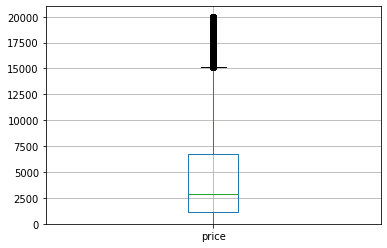

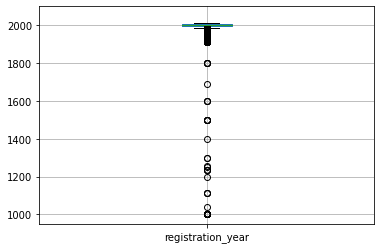

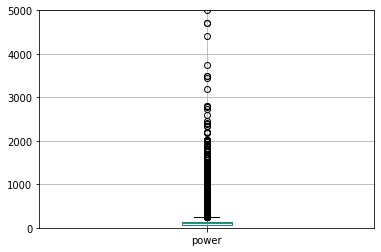

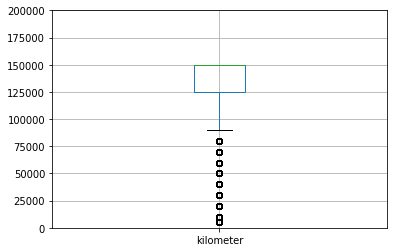

In [13]:
plt.ylim(0, 21000)
df.boxplot(column=['price'])
plt.show()

plt.ylim(950, 2100)
df.boxplot(column=['registration_year'])
plt.show()

plt.ylim(0, 5000)
df.boxplot(column=['power'])
plt.show()

plt.ylim(0, 200_000)
df.boxplot(column=['kilometer'])
plt.show()

**Вывод:**

* в столбце `registrationyear` были обнаружены объявления из будущего и автомобили загрестированные до 1768 года (дата создания первого автомобиля) - избавимся от них.
* столбец `numberofpictures` содержит одно нулевое значение и неинформативен - удалим его.
* есть объявления с л.с. `Power` равным 0. Наиболее вероятно, что речь идёт об электротранспорте. Спецтехника может иметь около 2000 л.с., удалим из выборки выбросы более 2000 л.с.

In [14]:
df = df.query("2001 > power")
df.reset_index(drop=True, inplace=True)

In [15]:
df = df.query("2024 > registration_year > 1768")
df.reset_index(drop=True, inplace=True)

In [16]:
df = df.query("2020 > registration_year > 1768")
df.reset_index(drop=True, inplace=True)

In [17]:
print('Минимальный год регистрации авто:', df['registration_year'].min())
print('Максимальный год регистрации авто:', df['registration_year'].max())

Минимальный год регистрации авто: 1800
Максимальный год регистрации авто: 2015


In [18]:
df['registration_year'].sort_values()

166982    1800
284585    1800
184571    1800
31211     1800
52994     1910
          ... 
88579     2015
223363    2015
49059     2015
158031    2015
150591    2015
Name: registration_year, Length: 286571, dtype: int64

Удалим аномалии с нулевой и крайне низкой ценой:

In [19]:
df = df.query('price > 50')

Посмотрим процент пропусков в столбцах:

In [20]:
pd.DataFrame(df.isna().mean().round(
             4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
repaired,17.980000
fuel_type,6.880000
model,4.820000
gearbox,4.300000
vehicle_type,3.520000
brand,0.000000
kilometer,0.000000
power,0.000000
registration_year,0.000000
price,0.000000


**Вывод:** 
* множество пропусков данных в столце `repaired`. В качестве решения можем заполнить часть пропусков, учитывая пробег и возраст автомобиля. Наиболее вероятно, что автомобиль с пробегом более 100_000 км или возрастом более 10 лет хотя раз был в ремонте. И наоборот автомобиль с пробегом до 10_000 км и возрастом до 1 года, наиболее вероятно не ремонтировался. В рамкой данной задачи упростим ситуацию и заменим пропуски на "unknown".

* пропуски в модели `model` cоставляют 5.9%. Для их восплонения нужно обратиться к заказчику. Удалим их.

* пропуски в типе коробке `gearbox` - 5.5%, типе автомобильного кузова `vehicle_type` cоставляют около 11.1%, в типе топлива `fuel_type` - 9.9%. Данные параметры c большой вероятностью одинаковы в одинаковых моделях автомобилей. Заполним пропуски в данных признаках наиболее частым значением той же модели.

In [21]:
df['repaired'].fillna('unknown', inplace=True)

In [22]:
df.dropna(subset=['model'], inplace=True)
df.reset_index(drop=True)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
263872,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
263873,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
263874,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
263875,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Заполним пропуски в признаках `gearbox`, `vehicle_type`, `fuel_type` наиболее частым значением той же модели:

In [23]:
for sing in ['vehicle_type', 'gearbox', 'fuel_type']:
    df[sing] = df[sing].fillna(df
                                .groupby('model')['vehicle_type']
                                .transform(lambda x: x.value_counts().idxmax())
                                        )

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263877 entries, 0 to 286570
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              263877 non-null  int64 
 1   vehicle_type       263877 non-null  object
 2   registration_year  263877 non-null  int64 
 3   gearbox            263877 non-null  object
 4   power              263877 non-null  int64 
 5   model              263877 non-null  object
 6   kilometer          263877 non-null  int64 
 7   fuel_type          263877 non-null  object
 8   brand              263877 non-null  object
 9   repaired           263877 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.1+ MB


In [25]:
df.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unknown
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Пропусков нет:

In [27]:
pd.DataFrame(df.isna().mean().round(
             4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
repaired,0.000000
brand,0.000000
fuel_type,0.000000
kilometer,0.000000
model,0.000000
power,0.000000
gearbox,0.000000
registration_year,0.000000
vehicle_type,0.000000
price,0.000000


In [28]:
df['power'] = df['power'].astype('int64')

Проверим данные с помощью корреляции Пирсона на наличие сильно-скоррелированных признаков:

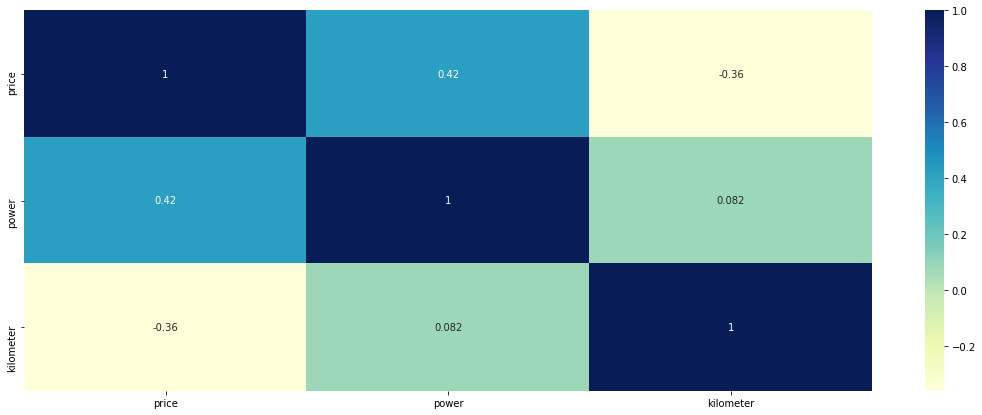

In [29]:
plt.figure(figsize=(19, 7))
df_0_plot = sns.heatmap(df[['price', 'power', 'kilometer']].corr(),
                          cmap="YlGnBu",
                          annot=True)

plt.show()

**Вывод:**

Из корелляции Пирсона можно сделать вывод об отсутсвии сильно-скоррелированных признаков, а так же отметить значительную зависимость между пробегом и ремонтом автомобиля, как и предполагалось ранее. Так же видна логичная весомая зависимость между годом регистрации и стоимостью автомобиля.

Построим матрицу корреляций Спирмена для числовых признаков без учёта объектов-выбросов:

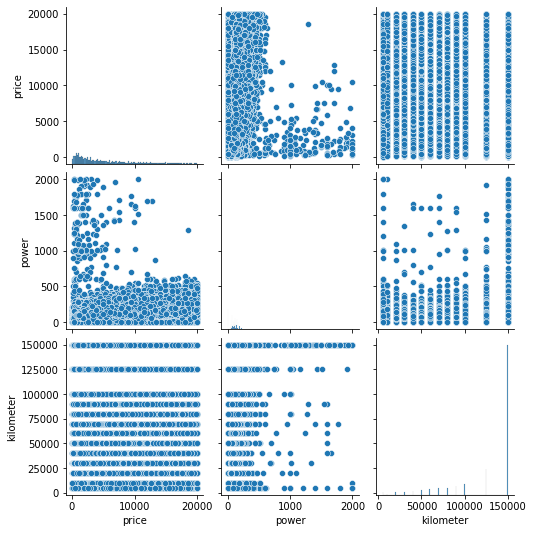

In [30]:
numeric = ['price', 'power', 'kilometer']

sns.pairplot(df[numeric])

In [31]:
df[numeric].corr(method='spearman')

,price,power,kilometer
price,1.000000,0.510347,-0.346629
power,0.510347,1.000000,0.106898
kilometer,-0.346629,0.106898,1.000000


Функция heatmap библиотеки Seaborn предоставляет удобный способ визуализации таких матриц:

<AxesSubplot:>

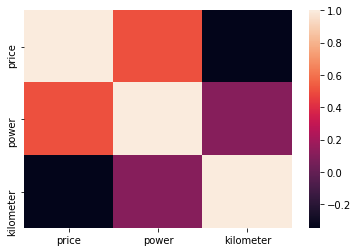

In [32]:
sns.heatmap(df[numeric].corr(method='spearman'))

**Вывод:**

Наибольшая коррцеляция наблюдается между признаками `price` и `power`.

Проведём статистические тесты:

In [33]:
r0 = spearmanr(df['price'], df['power'])
print('Spearman correlation:', r0[0], 'p-value:', r0[1])

Spearman correlation: 0.5103474543949347 p-value: 0.0


In [34]:
r1 = spearmanr(df['price'], df['kilometer'])
print('Spearman correlation:', r1[0], 'p-value:', r1[1])

Spearman correlation: -0.3466294618805373 p-value: 0.0


**Вывод:**

Так как p-value < 0.05 (типичное пороговое значение), то делаем вывод о том, что взаимосвязь (корреляция) между ценой и мощностью/километражем **статистически значима**.

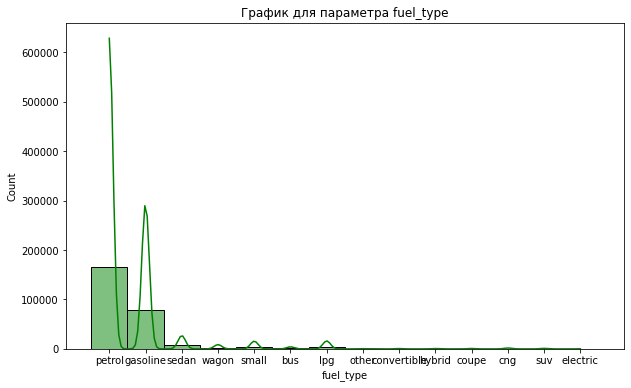

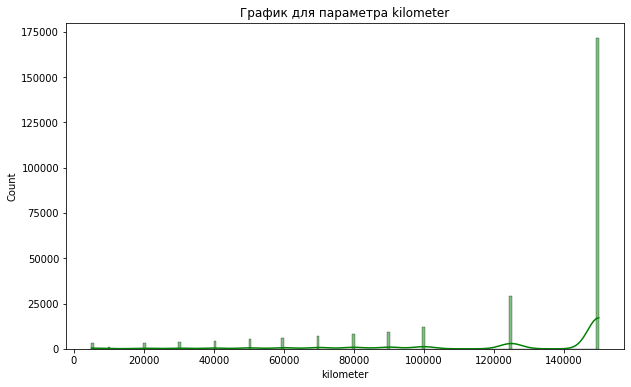

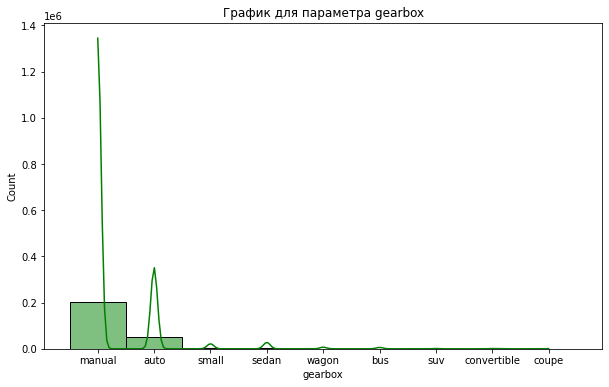

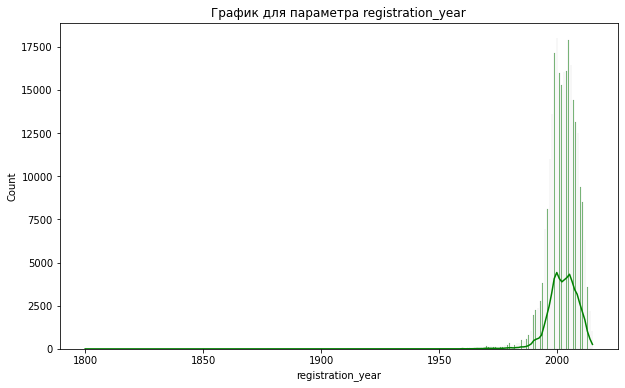

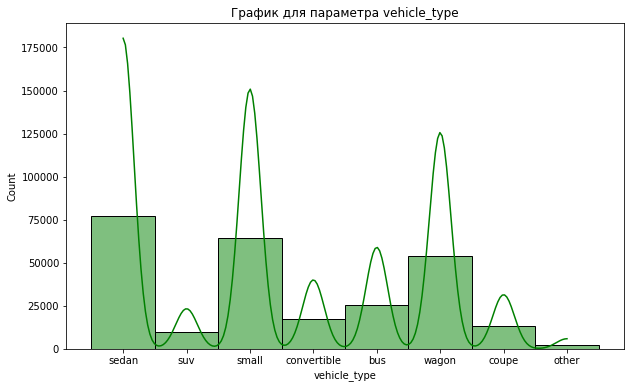

In [35]:
columns = ['fuel_type',
           'kilometer',
           'gearbox',
           'registration_year',
           'vehicle_type']

for name in columns:
    plt.figure(figsize=(10,6))
    sns.histplot(df[name],
                 color='green',
                 kde=True)
    plt.title(f'График для параметра {name}')

    plt.show()


In [37]:
df.nunique()

price                3587
vehicle_type            8
registration_year      87
gearbox                 9
power                 563
model                 250
kilometer              13
fuel_type              14
brand                  39
repaired                3
dtype: int64

**Вывод:**

Проанализиурем распределение данных в нашей выборке:

* в выборке представлены 39 брендов и 250 различных моделей транспорта;
* самый популярный тип двигателя - бензиновый;
* медиана распределения года авто по выборке ~ 2005 год;
* больше всего автомобилей с пробегом 150 тыс. км. **Вероятно, что в данных это была максимальная отметка для автомобиля.** По факту распределение пробега может оказаться другим;
* самая популярная трансмиссия - ручаня коробка передач. По количеству она во много раз превышает автоматическую;
* самый популярный кузов - седан.

In [38]:
df.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unknown
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Категориальные признаки закодируем one-hot encoding:

In [39]:
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.head(5)

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,480,1993,0,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Разделим выборки на обучающую и тестовую:

In [40]:
target_ohe = data_ohe['price']
features_ohe = data_ohe.drop('price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target_ohe,
                                                                                            test_size=0.25,
                                                                                            random_state=RANDOM_STATE) 


print(features_train_ohe.shape)
print(features_test_ohe.shape)

(197907, 320)
(65970, 320)


In [41]:
numeric = list(data_ohe)
numeric.remove('price')
print (numeric)

['registration_year', 'power', 'kilometer', 'vehicle_type_convertible', 'vehicle_type_coupe', 'vehicle_type_other', 'vehicle_type_sedan', 'vehicle_type_small', 'vehicle_type_suv', 'vehicle_type_wagon', 'gearbox_bus', 'gearbox_convertible', 'gearbox_coupe', 'gearbox_manual', 'gearbox_sedan', 'gearbox_small', 'gearbox_suv', 'gearbox_wagon', 'model_145', 'model_147', 'model_156', 'model_159', 'model_1_reihe', 'model_1er', 'model_200', 'model_2_reihe', 'model_300c', 'model_3_reihe', 'model_3er', 'model_4_reihe', 'model_500', 'model_5_reihe', 'model_5er', 'model_601', 'model_6_reihe', 'model_6er', 'model_7er', 'model_80', 'model_850', 'model_90', 'model_900', 'model_9000', 'model_911', 'model_a1', 'model_a2', 'model_a3', 'model_a4', 'model_a5', 'model_a6', 'model_a8', 'model_a_klasse', 'model_accord', 'model_agila', 'model_alhambra', 'model_almera', 'model_altea', 'model_amarok', 'model_antara', 'model_arosa', 'model_astra', 'model_auris', 'model_avensis', 'model_aveo', 'model_aygo', 'model

Масштабируем признаки:

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [ ]:
features_train_ohe.head()

In [ ]:
data_ohe.info()

**Вывод по разделу:**

В этом разделе мы произвели предобработку данных. Мы перевели названия столбцов в более удобочитаемый нижний и змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий, проверили корреляцию Пирсона и сделали визулизацию распределения ключевых признаков. Удалили дубликаты и перевели категориальные значения столбцов в количественные. В итоге у нас образовалась таблица в 263 тыс. строк и 319 столбцов размером 89.8 МВ.

## Обучение моделей

### Модель линейной регрессии:

In [ ]:
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)

predictions_train_ohe = model.predict(features_train_ohe)

rmse = mean_squared_error(target_train_ohe, predictions_train_ohe)**0.5
print('RMSE:', rmse)

scores = cross_val_score(model,
                         features_train_ohe,
                         target_train_ohe,
                         cv=5)

final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

**Вывод:**


Значения RMSE высоки и не вписываются в лимит задачи.

### Модель решающего дерева:

Закодируем признаки с помощью порядкового кодирования, которая предпочтительнее для моделей решающего дерева:

Разделим выборки на обучающую и тестовую:

In [ ]:
target_oe = df['price']
features_oe = df.drop('price', axis=1)
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(features_oe,
                                                                                        target_oe,
                                                                                        test_size=0.25,
                                                                                        random_state=RANDOM_STATE) 


print(features_train_oe.shape)
print(features_test_oe.shape)

In [ ]:
features_oe.head(5)

In [ ]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(features_train_oe[['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'repaired']])

features_train_oe[['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'repaired']] = enc.transform(features_train_oe[['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'repaired']])

features_test_oe[['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'repaired']] = enc.transform(features_test_oe[['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'repaired']])

In [ ]:
features_train_oe.head(5)

Построим модель для решающего дерева и найдем наилучшие гиперпараметры.

In [ ]:
for depth in range(3, 20, 3):
    model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth = depth)
    model.fit(features_train_oe, target_train_oe)
    predictions_train_oe = model.predict(features_train_oe)
    rmse = mean_squared_error(target_train_oe, predictions_train_oe)**0.5
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse)
    print('')
print()

scores = cross_val_score(model,
                         features_train_oe,
                         target_train_oe,
                         cv=5)

final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

**Вывод:**


Модель склонна к переобучению. Стоит ограничить глубину дерева до 9.

### Модель случайного леса:

In [ ]:
%%time
for est in [100, 500]:
    model = RandomForestRegressor(random_state=RANDOM_STATE, 
                                   n_estimators=est, 
                                   max_depth=9)
    model.fit(features_train_oe, target_train_oe)
    predictions_train_oe = model.predict(features_train_oe)
    rmse = mean_squared_error(target_train_oe, predictions_train_oe)**0.5
    print('Количество деревьев:', est)
    print('RMSE для случайного леса:', rmse)
    print('')
print()

scores = cross_val_score(model,
                         features_train_oe,
                         target_train_oe,
                         cv=5)

final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

**Вывод:**


Разница в установленных значения количества деревьев оказало незначительное вленияие на RMSE.

### LightGBM

Проверим версию:

In [ ]:
import lightgbm
print(lightgbm.__version__)

In [ ]:
target = df['price']
features = df.drop('price', axis=1)


for c in features.columns:
  col_type = features[c].dtype
  if col_type == 'object':
    features[c] = features[c].astype('category')


features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE) 


print(features_train.shape)
print(features_test.shape)

Построим модель без подбора гиперпараметров:

In [ ]:
model = lgb.LGBMRegressor(random_state=RANDOM_STATE)
model.fit(features_train, target_train)
predictions_train_light = model.predict(features_train)
rmse = mean_squared_error(target_train, predictions_train_light)**0.5
print('LightGBM RMSE:', rmse)

scores = cross_val_score(model,
                         features_train,
                         target_train,
                         cv=5)

final_score = sum(scores) / len(scores)
print('Средняя оценка качества модели:', final_score)

**Вывод:**

У LightGBM самая высокая средняя оценка качества модели: 0.86.

Найдем наилучшие гиперпараметры для LightGBM:

In [ ]:
param_grid = {'n_estimators': [100, 200, 500],
              'num_leaves': [n for n in range(0, 200, 20)]}

In [ ]:
model = lgb.LGBMRegressor(random_state=RANDOM_STATE)

tuning_model=GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

tuning_model.fit(features_train, target_train)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

**Вывод:**


Мы обучили разные модели, подобрали гиперпараметры для них и обнаружили, что модель LightGBM с гиперпараметрами 'n_estimators': 200, 'num_leaves': 180 дает наименьшее значение RMSE: 1567.25

**Выводы по разделу:**

Мы обучили 4 модели и посмотрели их RMSE:

Итоги:

* Линеная регрессия - RMSE: 2702.06
* Решающее дерево RMSE: 2143.24
* Случайны лес RMSE: 2050.46
* LightGBM RMSE: 1567.25

## Анализ моделей

### Модель линейной регрессии

Найдем время обучения модели линейной регрессии:

In [ ]:
%%time

model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)

In [ ]:
%%time

predictions_train_ohe = model.predict(features_train_ohe)

### Модель решающего дерева

Найдем время обучения модели решающего дерева:

In [ ]:
%%time

model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=9)
model.fit(features_train_oe, target_train_oe)

In [ ]:
%%time

predictions_train_oe = model.predict(features_train_oe)

### Модель случайного леса

Обучим модель случайного леса:

In [ ]:
%%time

model = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=9, n_estimators=1000)
model.fit(features_train_oe, target_train_oe)

In [ ]:
%%time

predictions_train_oe = model.predict(features_train_oe)

### Модель LightGBM

Найдем время обучения LightGBM:

In [ ]:
%%time
model = lgb.LGBMRegressor(random_state=RANDOM_STATE,
                          n_estimators=200,
                          num_leaves=180)
model.fit(features_train, target_train)

In [ ]:
%%time

predictions_train = model.predict(features_train)

In [ ]:
predictions_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions_test)**0.5
print('RMSE', rmse)

Посмотрим на самые значимые признаки:

In [ ]:
lgb.plot_importance(model, height=.5)

In [ ]:
x_ax = range(len(target_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, target_test, label="original")
plt.plot(x_ax, predictions_test, label="predicted")
plt.title("Определение стоимости автомобилей: тестовые и предсказанные данные")
plt.xlabel('features')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

**Общий вывод по разделу:**


Дольше всего учится модель случайного леса: 3 мин 22 сек. Модель LightGBM имеет приемлемую скорость обучения и предсказания 12.4 сек и при этом самую низкую RMSE из всех моделей: на тестовой выборке результат 1567.25

## Общий вывод

На входе мы получили таблицу с более чем 264 тыс. строк и 321 столбцов размером 89 МВ. Мы перевели названия столбцов в более читаемый нижний и змеиный регистр, удалили неинформативные столбцы, заполнили пропуски и предложили варианты их заполнения, избавились от аномалий, удалили дубликаты.

Для модели линейной регрессии перевели категориальные значения столбцов в количественные. Для моделей решающего дерева и случайного леса применили порядковое кодирование, в итоге подбор гиперпараметров стал быстрее. Мы обучили 4 разные модели, подобрали гиперпараметры для них и обнаружили, что модель LightGBM с гиперпараметрами 'n_estimators': 200, 'num_leaves': 180 дает наименьшее значение rmse: 1567.25

Мы проанализировали 4 модели и обнаружили, что дольше всего учится модель случайного леса: 2 мин 24 сек. Модель LightGBM имеет приемлемую скорость обучения и предсказания 12.4 сек и при этом самую низкую RMSE из всех моделей: на тестовой выборке результат 1567.25

**Итог:**

Исходя из требований заказчика мы рекомендуем модель LightGBM, которая показала лучшие результаты по всем параметрам.